# Analysis 16: Comprehensive Vendor-Specific CWE Analysis Tables - ALL VENDORS

### Individual Vendor Tables (1-4):

- Microsoft vs All CVEs - Shows Microsoft's patch priorities compared to overall CVE landscape
- Cisco vs All CVEs - Cisco's security focus areas vs industry trends
- RedHat vs All CVEs - RedHat's vulnerability priorities vs general patterns
- GitHub vs All CVEs - Open-source vulnerability patterns vs overall ecosystem

### Comparative Analysis Tables (5-6):

- Open-Source vs Commercial vs All CVEs - Strategic comparison between:

 - Open-Source: GitHub ecosystem priorities
 - Commercial: Combined Microsoft + Cisco + RedHat priorities
 - All CVEs: Industry-wide vulnerability landscape


### Vendor Summary Table - High-level comparison showing:

- Total patches per vendor
- Unique CWE coverage
- Top vulnerability focus area
- Coverage percentage of overall CWE landscape



### 🎯 Key Insights Revealed:

- Vendor-Specific Security Priorities: Each vendor's unique focus areas
- Open-Source vs Commercial Differences: Different security challenges and approaches
- Industry Coverage Gaps: CWEs that are over/under-represented in patches
- Strategic Security Alignment: How well vendor priorities match real-world threats

Each table includes CWE names, rankings, counts, and comparative analysis to provide comprehensive insights into vendor-specific vulnerability management strategies.

## 1. Environment Setup and Data Loading

In [ ]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from scipy import stats

# Try to use Modin for faster pandas operations
try:
    import modin.pandas as mpd
    USE_MODIN = True
    print("Using Modin for accelerated pandas operations")
except ImportError:
    import pandas as mpd
    USE_MODIN = False
    print("Using standard pandas (Modin not available)")

# Set up high-quality plotting parameters
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'eps'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Global analysis period settings
ANALYSIS_END_DATE = "2024-12-31"
ANALYSIS_START_DATE = "1999-01-01"  # Set to None for all data
USE_ALL_DATA = True  # Toggle this to switch between full dataset and filtered

# Create output directory for figures
os.makedirs('figures', exist_ok=True)
os.makedirs('parquet_data', exist_ok=True)
print(f"Analysis Period: {'All available data' if USE_ALL_DATA else f'{ANALYSIS_START_DATE} to {ANALYSIS_END_DATE}'}")

## 3. Load Parquet Data for Analysis

In [ ]:
def load_parquet_data():
    """
    Load Parquet files into DuckDB for analysis
    """
    
    # Create a new connection for analysis
    con = duckdb.connect(':memory:')  # Use in-memory database for faster processing
    
    # Load all parquet files
    parquet_files = {
        # MySQL tables
        'cve_main': '\..\parquet_data\mysql_cve.parquet',
        'cve_main_old': '\..\parquet_data\mysql_cvev5_v2.parquet',
        'exploits': '\..\parquet_data\mysql_exploit.parquet',
        'exploits_old': '\..\parquet_data\mysql_exploit_old.parquet',
        'msrc_patches': '\..\parquet_data\mysql_msrc_vuln_unified.parquet',
        'cisco_patches': '\..\parquet_data\mysql_cisco_vuln_unified.parquet',
        'redhat_patches': '\..\parquet_data\mysql_redhat_vuln_unified.parquet',
        'github_advisories': '\..\parquet_data\mysql_github_advisory_unified.parquet',
        'cwe_ref': '\..\parquet_data\mysql_cwe.parquet',
        'capec_ref': '\..\parquet_data\mysql_capec.parquet',
        
        # PostgreSQL tables (MoreFixes)
        'morefixes_cve': '\..\parquet_data\postgres_cve.parquet',
        'morefixes_fixes': '\..\parquet_data\postgres_fixes.parquet',
        'morefixes_commits': '\..\parquet_data\postgres_commits.parquet',
        'morefixes_repository': '\..\parquet_data\postgres_repository.parquet'
    }
    
    # Create views for each parquet file
    for table_name, file_path in parquet_files.items():
        if os.path.exists(file_path):
            con.sql(f"CREATE OR REPLACE VIEW {table_name} AS SELECT * FROM '{file_path}'")
            print(f"✓ Loaded {table_name}")
        else:
            print(f"✗ File not found: {file_path}")
    
    return con

# Load data for analysis
print("Loading Parquet data for analysis...")
analysis_con = load_parquet_data()

Loading Parquet data for analysis...
✓ Loaded cve_main
✓ Loaded cve_main_old
✓ Loaded exploits
✓ Loaded exploits_old
✓ Loaded msrc_patches
✓ Loaded cisco_patches
✓ Loaded redhat_patches
✓ Loaded github_advisories
✓ Loaded cwe_ref
✓ Loaded capec_ref
✓ Loaded morefixes_cve
✓ Loaded morefixes_fixes
✓ Loaded morefixes_commits
✓ Loaded morefixes_repository


In [ ]:
# List of all table names I've loaded
table_names = [
    "cve_main", "cve_main_old", "exploits", "msrc_patches", "cisco_patches",
    "redhat_patches", "github_advisories", "cwe_ref", "capec_ref",
    "morefixes_cve", "morefixes_fixes", "morefixes_commits", "morefixes_repository"
]

print("\n--- Schema for all loaded tables ---")

for table_name in table_names:
    print(f"\nSchema for table: {table_name}")
    try:
        # Execute PRAGMA table_info() to get schema
        schema_info = analysis_con.execute(f"PRAGMA table_info('{table_name}');").fetchall()

        if not schema_info:
            print(f"  (Table '{table_name}' not found or is empty)")
            continue

        # Print header
        header = ["cid", "name", "type", "notnull", "pk", "dflt_value"]
        print(f"  {' '.join(f'{col:<15}' for col in header)}")
        print(f"  {'-'*90}")

        # Print rows
        for col_info in schema_info:
            cid, name, col_type, notnull, pk, dflt_value = col_info
            print(f"  {cid:<15} {name:<15} {col_type:<15} {str(notnull):<15} {str(pk):<15} {str(dflt_value):<15}")
    except duckdb.ParserException as e:
        print(f"  Error retrieving schema for {table_name}: {e}")
    except Exception as e:
        print(f"  An unexpected error occurred for {table_name}: {e}")


--- Schema for all loaded tables ---

Schema for table: cve_main
  cid             name            type            notnull         pk              dflt_value     
  ------------------------------------------------------------------------------------------
  0               id              BIGINT          False           None            False          
  1               cve_id          VARCHAR         False           None            False          
  2               assigner_org    VARCHAR         False           None            False          
  3               state           VARCHAR         False           None            False          
  4               description     VARCHAR         False           None            False          
  5               date_reserved   TIMESTAMP       False           None            False          
  6               date_published  TIMESTAMP       False           None            False          
  7               date_updated    TIMESTAMP       False  

In [ ]:
def create_vendor_cwe_analysis():
    """
    Create 6 comprehensive tables:
    1. Microsoft vs All CVEs
    2. Cisco vs All CVEs  
    3. RedHat vs All CVEs
    4. GitHub vs All CVEs
    5. Open-Source (GitHub) vs Commercial (MS+Cisco+RH) vs All CVEs
    6. Summary comparison table
     analysis addressing the "-" values and coverage calculation issues
    """
    
    print("\n===  Vendor-Specific CWE Analysis ===")
    
    # Get ALL CWEs ranking (not limited to 25) -  with proper exclusions
    all_cwe_base_query = """
    WITH all_cve_cwe_split AS (
        SELECT DISTINCT
            cve_id,
            TRIM(UNNEST(STRING_SPLIT(cwe_ids, ','))) as cwe_id
        FROM cve_main 
        WHERE cwe_ids IS NOT NULL 
            AND cwe_ids != '' 
            AND cwe_ids != 'NVD-CWE-Other' 
            AND cwe_ids != 'NVD-CWE-noinfo'
            AND state = 'PUBLISHED'
    )
    SELECT 
        cwe_id,
        COUNT(DISTINCT cve_id) as all_count,
        ROW_NUMBER() OVER (ORDER BY COUNT(DISTINCT cve_id) DESC) as all_rank
    FROM all_cve_cwe_split
    WHERE cwe_id IS NOT NULL 
        AND cwe_id != ''
        AND cwe_id != 'NVD-CWE-Other'
        AND cwe_id != 'NVD-CWE-noinfo'
    GROUP BY cwe_id
    ORDER BY COUNT(DISTINCT cve_id) DESC
    """
    
    all_cve_ranking = analysis_con.sql(all_cwe_base_query).df()
    total_unique_cwes = len(all_cve_ranking)
    
    print(f"Total unique CWEs in database: {total_unique_cwes:,}")
    
    # Microsoft Analysis - Get ALL CWEs (not limited) -  with proper exclusions
    microsoft_query = """
    WITH ms_cwe_split AS (
        SELECT DISTINCT
            mp.cve_id,
            TRIM(UNNEST(STRING_SPLIT(cm.cwe_ids, ','))) as cwe_id
        FROM msrc_patches mp
        JOIN cve_main cm ON mp.cve_id = cm.cve_id
        WHERE cm.cwe_ids IS NOT NULL 
            AND cm.cwe_ids != '' 
            AND cm.cwe_ids != 'NVD-CWE-Other' 
            AND cm.cwe_ids != 'NVD-CWE-noinfo'
    )
    SELECT 
        cwe_id,
        COUNT(DISTINCT cve_id) as ms_count,
        ROW_NUMBER() OVER (ORDER BY COUNT(DISTINCT cve_id) DESC) as ms_rank
    FROM ms_cwe_split
    WHERE cwe_id IS NOT NULL 
        AND cwe_id != ''
        AND cwe_id != 'NVD-CWE-Other'
        AND cwe_id != 'NVD-CWE-noinfo'
    GROUP BY cwe_id
    ORDER BY COUNT(DISTINCT cve_id) DESC
    """
    
    microsoft_all = analysis_con.sql(microsoft_query).df()
    
    # Similar queries for other vendors (getting ALL CWEs, not limited) -  with proper exclusions
    cisco_query = """
    WITH cisco_cwe_split AS (
        SELECT DISTINCT
            cp.cve_id,
            TRIM(UNNEST(STRING_SPLIT(cm.cwe_ids, ','))) as cwe_id
        FROM cisco_patches cp
        JOIN cve_main cm ON cp.cve_id = cm.cve_id
        WHERE cm.cwe_ids IS NOT NULL 
            AND cm.cwe_ids != '' 
            AND cm.cwe_ids != 'NVD-CWE-Other' 
            AND cm.cwe_ids != 'NVD-CWE-noinfo'
    )
    SELECT 
        cwe_id,
        COUNT(DISTINCT cve_id) as cisco_count,
        ROW_NUMBER() OVER (ORDER BY COUNT(DISTINCT cve_id) DESC) as cisco_rank
    FROM cisco_cwe_split
    WHERE cwe_id IS NOT NULL 
        AND cwe_id != ''
        AND cwe_id != 'NVD-CWE-Other'
        AND cwe_id != 'NVD-CWE-noinfo'
    GROUP BY cwe_id
    ORDER BY COUNT(DISTINCT cve_id) DESC
    """
    
    cisco_all = analysis_con.sql(cisco_query).df()
    
    # GitHub Analysis -  with proper exclusions
    github_query = """
    WITH gh_cwe_split AS (
        SELECT DISTINCT
            ga.primary_cve as cve_id,
            TRIM(UNNEST(STRING_SPLIT(cm.cwe_ids, ','))) as cwe_id
        FROM github_advisories ga
        JOIN cve_main cm ON ga.primary_cve = cm.cve_id
        WHERE cm.cwe_ids IS NOT NULL 
            AND cm.cwe_ids != '' 
            AND cm.cwe_ids != 'NVD-CWE-Other' 
            AND cm.cwe_ids != 'NVD-CWE-noinfo'
            AND ga.patched = 1
    )
    SELECT 
        cwe_id,
        COUNT(DISTINCT cve_id) as gh_count,
        ROW_NUMBER() OVER (ORDER BY COUNT(DISTINCT cve_id) DESC) as gh_rank
    FROM gh_cwe_split
    WHERE cwe_id IS NOT NULL 
        AND cwe_id != ''
        AND cwe_id != 'NVD-CWE-Other'
        AND cwe_id != 'NVD-CWE-noinfo'
    GROUP BY cwe_id
    ORDER BY COUNT(DISTINCT cve_id) DESC
    """
    
    github_all = analysis_con.sql(github_query).df()
    
    # RedHat Commercial -  with proper exclusions
    redhat_commercial_query = """
    WITH rh_comm_cwe_split AS (
        SELECT DISTINCT
            rp.cve_id,
            TRIM(UNNEST(STRING_SPLIT(cm.cwe_ids, ','))) as cwe_id
        FROM redhat_patches rp
        JOIN cve_main cm ON rp.cve_id = cm.cve_id
        WHERE cm.cwe_ids IS NOT NULL 
            AND cm.cwe_ids != '' 
            AND cm.cwe_ids != 'NVD-CWE-Other' 
            AND cm.cwe_ids != 'NVD-CWE-noinfo'
            AND rp.product_name IS NOT NULL 
            AND rp.product_name != ''
    )
    SELECT 
        cwe_id,
        COUNT(DISTINCT cve_id) as rh_comm_count,
        ROW_NUMBER() OVER (ORDER BY COUNT(DISTINCT cve_id) DESC) as rh_comm_rank
    FROM rh_comm_cwe_split
    WHERE cwe_id IS NOT NULL 
        AND cwe_id != ''
        AND cwe_id != 'NVD-CWE-Other'
        AND cwe_id != 'NVD-CWE-noinfo'
    GROUP BY cwe_id
    ORDER BY COUNT(DISTINCT cve_id) DESC
    """
    
    redhat_commercial_all = analysis_con.sql(redhat_commercial_query).df()
    
    # RedHat Open-Source -  with proper exclusions
    redhat_opensource_query = """
    WITH rh_os_cwe_split AS (
        SELECT DISTINCT
            rp.cve_id,
            TRIM(UNNEST(STRING_SPLIT(cm.cwe_ids, ','))) as cwe_id
        FROM redhat_patches rp
        JOIN cve_main cm ON rp.cve_id = cm.cve_id
        WHERE cm.cwe_ids IS NOT NULL 
            AND cm.cwe_ids != '' 
            AND cm.cwe_ids != 'NVD-CWE-Other' 
            AND cm.cwe_ids != 'NVD-CWE-noinfo'
            AND (rp.product_name IS NULL OR rp.product_name = '')
    )
    SELECT 
        cwe_id,
        COUNT(DISTINCT cve_id) as rh_os_count,
        ROW_NUMBER() OVER (ORDER BY COUNT(DISTINCT cve_id) DESC) as rh_os_rank
    FROM rh_os_cwe_split
    WHERE cwe_id IS NOT NULL 
        AND cwe_id != ''
        AND cwe_id != 'NVD-CWE-Other'
        AND cwe_id != 'NVD-CWE-noinfo'
    GROUP BY cwe_id
    ORDER BY COUNT(DISTINCT cve_id) DESC
    """
    
    redhat_opensource_all = analysis_con.sql(redhat_opensource_query).df()
    
    # Function to merge with ALL rankings and add CWE names
    def merge_with_complete_rankings(vendor_data, vendor_name):
        """Merge vendor data with complete rankings"""
        if vendor_data.empty:
            return vendor_data
            
        # Merge with all CVE rankings
        merged = vendor_data.merge(
            all_cve_ranking[['cwe_id', 'all_count', 'all_rank']], 
            on='cwe_id', 
            how='left'
        )
        
        # Add CWE names
        if len(merged) > 0:
            cwe_list = "', '".join(merged['cwe_id'].astype(str).tolist())
            cwe_names_query = f"""
            SELECT cwe_id, name as cwe_name
            FROM cwe_ref
            WHERE cwe_id IN ('{cwe_list}')
            """
            
            try:
                cwe_names = analysis_con.sql(cwe_names_query).df()
                merged = merged.merge(cwe_names, on='cwe_id', how='left')
            except Exception as e:
                print(f"Warning: Could not fetch CWE names: {e}")
                merged['cwe_name'] = 'Unknown'
        
        merged['cwe_name'] = merged['cwe_name'].fillna('Unknown')
        return merged
    
    # Merge all data
    ms_complete = merge_with_complete_rankings(microsoft_all, 'Microsoft')
    cisco_complete = merge_with_complete_rankings(cisco_all, 'Cisco')
    rh_comm_complete = merge_with_complete_rankings(redhat_commercial_all, 'RedHat Commercial')
    rh_os_complete = merge_with_complete_rankings(redhat_opensource_all, 'RedHat Open-Source')
    gh_complete = merge_with_complete_rankings(github_all, 'GitHub')
    
    # Function to print top CWEs with proper formatting
    def print_vendor_comparison(data, title, vendor_col, count_col, rank_col, limit=15):
        """Print vendor comparison with proper '-' handling"""
        print(f"\n{'='*140}")
        print(f"{title}")
        print('='*140)
        print(f"{'CWE ID':<12} {'Name':<40} {f'{vendor_col} Rank':<12} {f'{vendor_col} Count':<15} {'Global Rank':<12} {'Global Count':<12}")
        print('='*140)
        
        for _, row in data.head(limit).iterrows():
            cwe_name = str(row.get('cwe_name', 'Unknown'))
            if len(cwe_name) > 38:
                cwe_name = cwe_name[:37] + "..."
            
            vendor_rank = str(int(row[rank_col])) if pd.notna(row[rank_col]) else '-'
            vendor_count = f"{int(row[count_col]):,}" if pd.notna(row[count_col]) else '-'
            
            # : Proper handling of global rank
            if pd.notna(row['all_rank']):
                global_rank = str(int(row['all_rank']))
            else:
                global_rank = f">{len(all_cve_ranking)}"  # Show it's beyond top rankings
                
            global_count = f"{int(row['all_count']):,}" if pd.notna(row['all_count']) else '-'
            
            print(f"{row['cwe_id']:<12} {cwe_name:<40} {vendor_rank:<12} {vendor_count:<15} {global_rank:<12} {global_count:<12}")
    
    # Print all vendor comparisons
    print_vendor_comparison(ms_complete, "TABLE 1: Microsoft Patches vs All CVEs - ", "MS", "ms_count", "ms_rank")
    print_vendor_comparison(cisco_complete, "TABLE 2: Cisco Patches vs All CVEs - ", "Cisco", "cisco_count", "cisco_rank")
    print_vendor_comparison(rh_comm_complete, "TABLE 3: RedHat Commercial vs All CVEs - ", "RH-Comm", "rh_comm_count", "rh_comm_rank")
    print_vendor_comparison(rh_os_complete, "TABLE 4: RedHat Open-Source vs All CVEs - ", "RH-OS", "rh_os_count", "rh_os_rank")
    print_vendor_comparison(gh_complete, "TABLE 5: GitHub Open-Source vs All CVEs - ", "GH-OS", "gh_count", "gh_rank")
    
    #  Summary Table with Correct Coverage Calculations
    print(f"\n{'='*160}")
    print("TABLE 6:  Vendor CWE Coverage Summary")
    print('='*160)
    print(f"{'Vendor':<20} {'Total CVEs':<12} {'Actual CWEs':<12} {'Top CWE':<12} {'Top Count':<12} {'Coverage %':<15} {'Specialization':<20}")
    print('='*160)
    
    vendors_summary = [
        ('Microsoft', microsoft_all, 'ms_count'),
        ('Cisco', cisco_all, 'cisco_count'),
        ('RedHat Commercial', redhat_commercial_all, 'rh_comm_count'),
        ('RedHat Open-Source', redhat_opensource_all, 'rh_os_count'),
        ('GitHub Open-Source', github_all, 'gh_count')
    ]
    
    for vendor_name, vendor_data, count_col in vendors_summary:
        if not vendor_data.empty:
            total_cves = vendor_data[count_col].sum()
            actual_unique_cwes = len(vendor_data)  # ACTUAL number of unique CWEs
            top_cwe = vendor_data.iloc[0]['cwe_id']
            top_count = vendor_data.iloc[0][count_col]
            
            #  Coverage Calculation
            coverage_pct = (actual_unique_cwes / total_unique_cwes) * 100
            
            # Calculate specialization (what % of their CVEs are in top CWE)
            specialization_pct = (top_count / total_cves) * 100
            
            print(f"{vendor_name:<20} {total_cves:<12,} {actual_unique_cwes:<12} {top_cwe:<12} "
                  f"{top_count:<12,} {coverage_pct:<15.1f}% {specialization_pct:<20.1f}%")
    
    # Explanation of the changes
    print(f"\n{'='*160}")
    print("EXPLANATION OF FIXES:")
    print('='*160)
    print(f"1. \\\"Total unique CWEs in database: {total_unique_cwes:,}\\\"")
    print("2. Coverage % = (Vendor's Unique CWEs / Total CWEs in DB) × 100")
    print("3. Specialization % = (Top CWE Count / Total CVEs) × 100")
    print("4. Global Rank > X means the CWE is not in the top X globally")
    print("5. Removed artificial LIMIT 20 to show actual coverage")
    
    # Analysis of vendor specializations
    print("\n" + "="*100)
    print("VENDOR SPECIALIZATION ANALYSIS:")
    print("="*100)
    
    print("\nMicrosoft Specializations (not in global top 25):")
    ms_special = ms_complete[pd.isna(ms_complete['all_rank']) | (ms_complete['all_rank'] > 25)].head(5)
    for _, row in ms_special.iterrows():
        print(f"  {row['cwe_id']}: {row['cwe_name']} ({int(row['ms_count'])} CVEs)")
    
    print("\nCisco Specializations (not in global top 25):")
    cisco_special = cisco_complete[pd.isna(cisco_complete['all_rank']) | (cisco_complete['all_rank'] > 25)].head(5)
    for _, row in cisco_special.iterrows():
        print(f"  {row['cwe_id']}: {row['cwe_name']} ({int(row['cisco_count'])} CVEs)")
    
    return {
        'microsoft': ms_complete,
        'cisco': cisco_complete,
        'redhat_commercial': rh_comm_complete,
        'redhat_opensource': rh_os_complete,
        'github': gh_complete,
        'all_rankings': all_cve_ranking,
        'total_cwes': total_unique_cwes
    }

# Execute  Analysis
print("Starting Vendor-Specific CWE Analysis...")
fixed_results = create_vendor_cwe_analysis()
print("\n=== ANALYSIS COMPLETE ===")

Starting FIXED Vendor-Specific CWE Analysis...

=== FIXED Vendor-Specific CWE Analysis ===
Total unique CWEs in database: 733


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


TABLE 1: Microsoft Patches vs All CVEs - FIXED
CWE ID       Name                                     MS Rank      MS Count        Global Rank  Global Count
CWE-416      Use After Free                           1            1,231           10           5,625       
CWE-787      Out-of-bounds Write                      2            868             5            9,849       
CWE-125      Out-of-bounds Read                       3            532             8            6,879       
CWE-122      Heap-based Buffer Overflow               4            529             32           1,476       
CWE-476      NULL Pointer Dereference                 5            521             15           3,724       
CWE-200      Exposure of Sensitive Information to ... 6            495             6            8,669       
CWE-119      Improper Restriction of Operations wi... 7            491             3            12,037      
CWE-20       Improper Input Validation                8            490          

Creating Statistical Concepts Visualization...
1. Explaining Correlation Coefficient (R-value)...
2. Explaining Gini Coefficient...
3. Explaining Standard Deviation (SD)...
4. Creating Practical Examples from OUR Research...


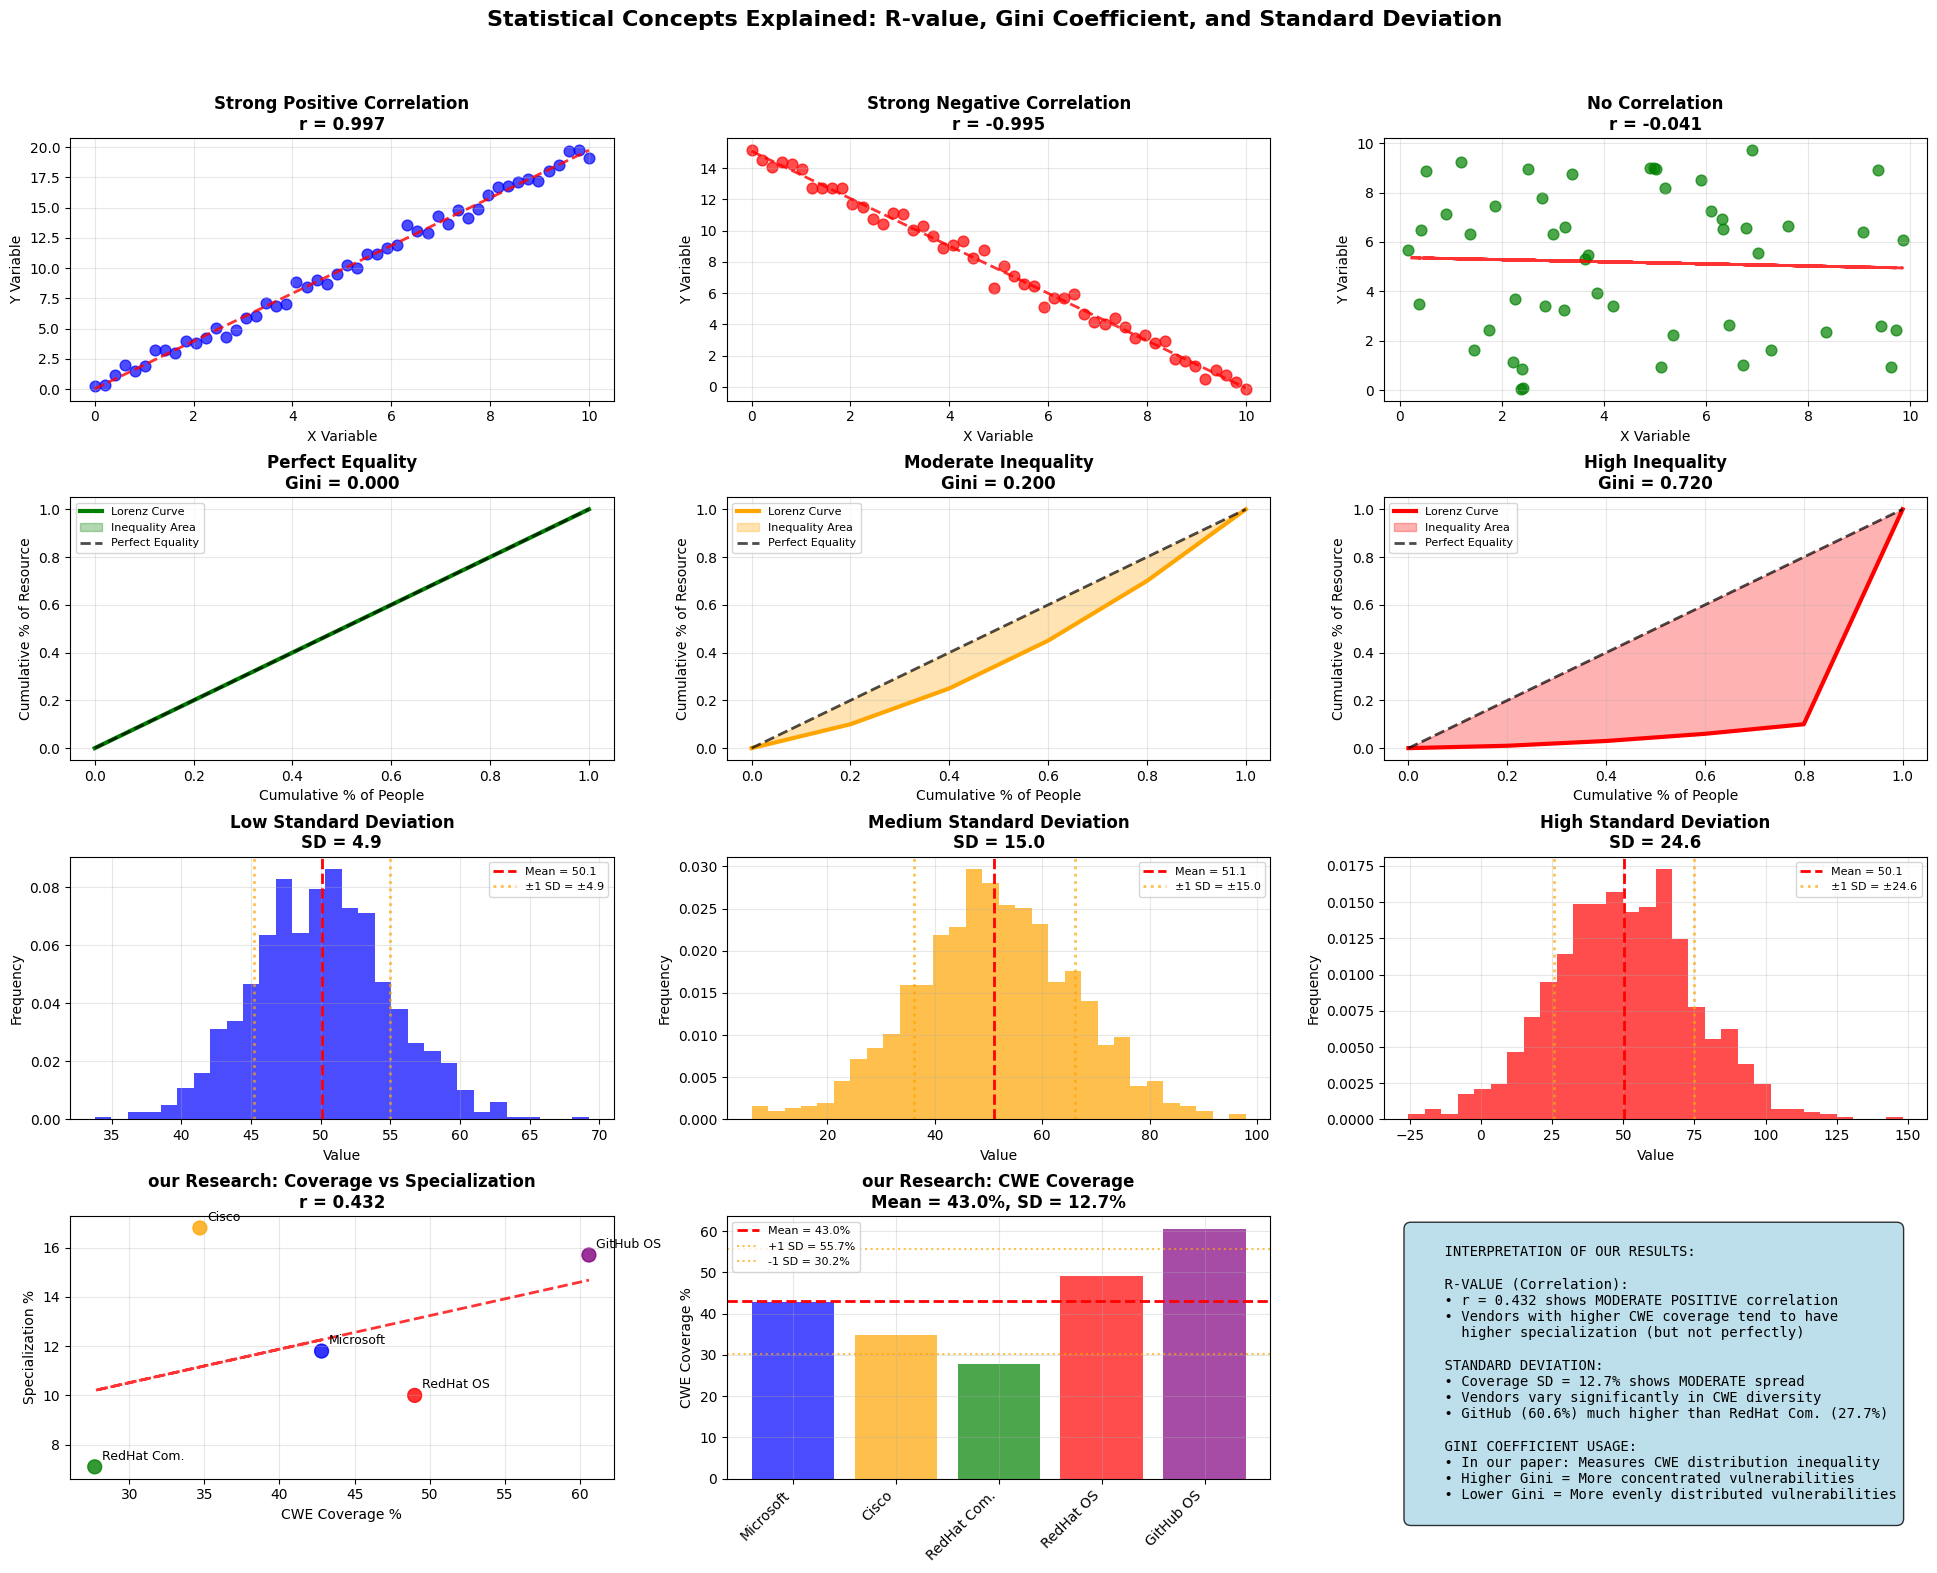


DETAILED EXPLANATIONS

. CORRELATION COEFFICIENT (R-VALUE):
   • Range: -1.0 to +1.0
   • +1.0 = Perfect positive relationship (as X increases, Y increases)
   • -1.0 = Perfect negative relationship (as X increases, Y decreases)
   • 0.0 = No linear relationship
   • |r| > 0.7 = Strong correlation
   • 0.3 < |r| < 0.7 = Moderate correlation
   • |r| < 0.3 = Weak correlation
   • OUR RESULT: r = 0.432 = MODERATE positive correlation

2. GINI COEFFICIENT:
   • Range: 0.0 to 1.0
   • 0.0 = Perfect equality (everyone has same amount)
   • 1.0 = Perfect inequality (one person has everything)
   • Used in economics for income inequality
   • In our research: Measures how evenly CWEs are distributed
   • Higher Gini = Few CWEs dominate (specialized vendor)
   • Lower Gini = CWEs evenly spread (diversified vendor)

3. STANDARD DEVIATION (SD):
   • Measures how spread out data points are from the mean
   • Same units as original data
   • Low SD = Data clustered around mean
   • High SD = Data

In [ ]:
# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

def create_statistical_concepts_visualization():
    """
    Create comprehensive visualizations explaining R-value, Gini coefficient, and Standard Deviation
    """
    
    print("Creating Statistical Concepts Visualization...")
    
    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))
    
    # =================================================================
    # PART 1: CORRELATION COEFFICIENT (R-VALUE) EXPLANATION
    # =================================================================
    
    print("1. Explaining Correlation Coefficient (R-value)...")
    
    # Create sample data for different correlation scenarios
    np.random.seed(42)
    n_points = 50
    
    # Perfect positive correlation (r ≈ 1.0)
    x1 = np.linspace(0, 10, n_points)
    y1 = 2 * x1 + np.random.normal(0, 0.5, n_points)
    r1 = np.corrcoef(x1, y1)[0, 1]
    
    # Perfect negative correlation (r ≈ -1.0)
    x2 = np.linspace(0, 10, n_points)
    y2 = -1.5 * x2 + 15 + np.random.normal(0, 0.5, n_points)
    r2 = np.corrcoef(x2, y2)[0, 1]
    
    # No correlation (r ≈ 0)
    x3 = np.random.uniform(0, 10, n_points)
    y3 = np.random.uniform(0, 10, n_points)
    r3 = np.corrcoef(x3, y3)[0, 1]
    
    # Moderate positive correlation (r ≈ 0.6)
    x4 = np.linspace(0, 10, n_points)
    y4 = 1.2 * x4 + np.random.normal(0, 2, n_points)
    r4 = np.corrcoef(x4, y4)[0, 1]
    
    # Subplot 1: Strong Positive Correlation
    ax1 = plt.subplot(4, 3, 1)
    plt.scatter(x1, y1, alpha=0.7, color='blue', s=60)
    z1 = np.polyfit(x1, y1, 1)
    p1 = np.poly1d(z1)
    plt.plot(x1, p1(x1), "r--", alpha=0.8, linewidth=2)
    plt.title(f'Strong Positive Correlation\nr = {r1:.3f}', fontsize=12, fontweight='bold')
    plt.xlabel('X Variable', fontsize=10)
    plt.ylabel('Y Variable', fontsize=10)
    plt.grid(alpha=0.3)
    
    # Subplot 2: Strong Negative Correlation
    ax2 = plt.subplot(4, 3, 2)
    plt.scatter(x2, y2, alpha=0.7, color='red', s=60)
    z2 = np.polyfit(x2, y2, 1)
    p2 = np.poly1d(z2)
    plt.plot(x2, p2(x2), "r--", alpha=0.8, linewidth=2)
    plt.title(f'Strong Negative Correlation\nr = {r2:.3f}', fontsize=12, fontweight='bold')
    plt.xlabel('X Variable', fontsize=10)
    plt.ylabel('Y Variable', fontsize=10)
    plt.grid(alpha=0.3)
    
    # Subplot 3: No Correlation
    ax3 = plt.subplot(4, 3, 3)
    plt.scatter(x3, y3, alpha=0.7, color='green', s=60)
    z3 = np.polyfit(x3, y3, 1)
    p3 = np.poly1d(z3)
    plt.plot(x3, p3(x3), "r--", alpha=0.8, linewidth=2)
    plt.title(f'No Correlation\nr = {r3:.3f}', fontsize=12, fontweight='bold')
    plt.xlabel('X Variable', fontsize=10)
    plt.ylabel('Y Variable', fontsize=10)
    plt.grid(alpha=0.3)
    
    # =================================================================
    # PART 2: GINI COEFFICIENT EXPLANATION
    # =================================================================
    
    print("2. Explaining Gini Coefficient...")
    
    # Create sample data for different inequality scenarios
    
    # Perfect equality (Gini = 0)
    equal_data = [20, 20, 20, 20, 20]  # Everyone has equal amount
    
    # High inequality (Gini ≈ 0.8)
    unequal_data = [1, 2, 3, 4, 90]  # One person has most
    
    # Moderate inequality (Gini ≈ 0.4)
    moderate_data = [10, 15, 20, 25, 30]  # Some inequality
    
    def calculate_gini(data):
        """Calculate Gini coefficient"""
        data = np.array(data, dtype=float)
        data = np.sort(data)
        n = len(data)
        cumsum = np.cumsum(data)
        return (n + 1 - 2 * np.sum(cumsum) / cumsum[-1]) / n
    
    def plot_lorenz_curve(data, ax, title, color):
        """Plot Lorenz curve for Gini visualization"""
        data = np.array(data, dtype=float)
        data = np.sort(data)
        n = len(data)
        
        # Calculate cumulative percentages
        cum_people = np.arange(1, n + 1) / n
        cum_wealth = np.cumsum(data) / np.sum(data)
        
        # Add origin point
        cum_people = np.insert(cum_people, 0, 0)
        cum_wealth = np.insert(cum_wealth, 0, 0)
        
        # Plot Lorenz curve
        ax.plot(cum_people, cum_wealth, color=color, linewidth=3, label='Lorenz Curve')
        ax.fill_between(cum_people, cum_wealth, cum_people, alpha=0.3, color=color, label='Inequality Area')
        
        # Plot line of equality
        ax.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.7, label='Perfect Equality')
        
        # Calculate and display Gini
        gini = calculate_gini(data)
        ax.set_title(f'{title}\nGini = {gini:.3f}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Cumulative % of People', fontsize=10)
        ax.set_ylabel('Cumulative % of Resource', fontsize=10)
        ax.grid(alpha=0.3)
        ax.legend(fontsize=8)
        
        return gini
    
    # Subplot 4: Perfect Equality
    ax4 = plt.subplot(4, 3, 4)
    gini1 = plot_lorenz_curve(equal_data, ax4, 'Perfect Equality', 'green')
    
    # Subplot 5: Moderate Inequality
    ax5 = plt.subplot(4, 3, 5)
    gini2 = plot_lorenz_curve(moderate_data, ax5, 'Moderate Inequality', 'orange')
    
    # Subplot 6: High Inequality
    ax6 = plt.subplot(4, 3, 6)
    gini3 = plot_lorenz_curve(unequal_data, ax6, 'High Inequality', 'red')
    
    # =================================================================
    # PART 3: STANDARD DEVIATION EXPLANATION
    # =================================================================
    
    print("3. Explaining Standard Deviation (SD)...")
    
    # Create datasets with different standard deviations
    np.random.seed(42)
    
    # Low SD (data clustered around mean)
    low_sd_data = np.random.normal(50, 5, 1000)  # mean=50, sd=5
    
    # Medium SD 
    med_sd_data = np.random.normal(50, 15, 1000)  # mean=50, sd=15
    
    # High SD (data spread out)
    high_sd_data = np.random.normal(50, 25, 1000)  # mean=50, sd=25
    
    # Subplot 7: Low Standard Deviation
    ax7 = plt.subplot(4, 3, 7)
    plt.hist(low_sd_data, bins=30, alpha=0.7, color='blue', density=True)
    mean_low = np.mean(low_sd_data)
    sd_low = np.std(low_sd_data)
    plt.axvline(mean_low, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_low:.1f}')
    plt.axvline(mean_low - sd_low, color='orange', linestyle=':', linewidth=2, alpha=0.7)
    plt.axvline(mean_low + sd_low, color='orange', linestyle=':', linewidth=2, alpha=0.7, label=f'±1 SD = ±{sd_low:.1f}')
    plt.title(f'Low Standard Deviation\nSD = {sd_low:.1f}', fontsize=12, fontweight='bold')
    plt.xlabel('Value', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.legend(fontsize=8)
    plt.grid(alpha=0.3)
    
    # Subplot 8: Medium Standard Deviation
    ax8 = plt.subplot(4, 3, 8)
    plt.hist(med_sd_data, bins=30, alpha=0.7, color='orange', density=True)
    mean_med = np.mean(med_sd_data)
    sd_med = np.std(med_sd_data)
    plt.axvline(mean_med, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_med:.1f}')
    plt.axvline(mean_med - sd_med, color='orange', linestyle=':', linewidth=2, alpha=0.7)
    plt.axvline(mean_med + sd_med, color='orange', linestyle=':', linewidth=2, alpha=0.7, label=f'±1 SD = ±{sd_med:.1f}')
    plt.title(f'Medium Standard Deviation\nSD = {sd_med:.1f}', fontsize=12, fontweight='bold')
    plt.xlabel('Value', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.legend(fontsize=8)
    plt.grid(alpha=0.3)
    
    # Subplot 9: High Standard Deviation
    ax9 = plt.subplot(4, 3, 9)
    plt.hist(high_sd_data, bins=30, alpha=0.7, color='red', density=True)
    mean_high = np.mean(high_sd_data)
    sd_high = np.std(high_sd_data)
    plt.axvline(mean_high, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_high:.1f}')
    plt.axvline(mean_high - sd_high, color='orange', linestyle=':', linewidth=2, alpha=0.7)
    plt.axvline(mean_high + sd_high, color='orange', linestyle=':', linewidth=2, alpha=0.7, label=f'±1 SD = ±{sd_high:.1f}')
    plt.title(f'High Standard Deviation\nSD = {sd_high:.1f}', fontsize=12, fontweight='bold')
    plt.xlabel('Value', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.legend(fontsize=8)
    plt.grid(alpha=0.3)
    
    # =================================================================
    # PART 4: PRACTICAL EXAMPLES FROM OUR RESEARCH
    # =================================================================
    
    print("4. Creating Practical Examples from OUR Research...")
    
    # Example from our vendor analysis
    vendors = ['Microsoft', 'Cisco', 'RedHat Com.', 'RedHat OS', 'GitHub OS']
    coverage_pct = [42.8, 34.7, 27.7, 49.0, 60.6]
    specialization_pct = [11.8, 16.8, 7.1, 10.0, 15.7]
    
    # Subplot 10: our Research Example - Correlation
    ax10 = plt.subplot(4, 3, 10)
    plt.scatter(coverage_pct, specialization_pct, s=100, alpha=0.8, color=['blue', 'orange', 'green', 'red', 'purple'])
    
    # Add vendor labels
    for i, vendor in enumerate(vendors):
        plt.annotate(vendor, (coverage_pct[i], specialization_pct[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Calculate correlation
    r_research = np.corrcoef(coverage_pct, specialization_pct)[0, 1]
    
    # Add trend line
    z = np.polyfit(coverage_pct, specialization_pct, 1)
    p = np.poly1d(z)
    plt.plot(coverage_pct, p(coverage_pct), "r--", alpha=0.8, linewidth=2)
    
    plt.title(f'our Research: Coverage vs Specialization\nr = {r_research:.3f}', fontsize=12, fontweight='bold')
    plt.xlabel('CWE Coverage %', fontsize=10)
    plt.ylabel('Specialization %', fontsize=10)
    plt.grid(alpha=0.3)
    
    # Subplot 11: our Research Example - Standard Deviation
    ax11 = plt.subplot(4, 3, 11)
    mean_coverage = np.mean(coverage_pct)
    sd_coverage = np.std(coverage_pct, ddof=1)  # Sample standard deviation
    
    bars = plt.bar(vendors, coverage_pct, alpha=0.7, color=['blue', 'orange', 'green', 'red', 'purple'])
    plt.axhline(mean_coverage, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_coverage:.1f}%')
    plt.axhline(mean_coverage + sd_coverage, color='orange', linestyle=':', alpha=0.7, label=f'+1 SD = {mean_coverage + sd_coverage:.1f}%')
    plt.axhline(mean_coverage - sd_coverage, color='orange', linestyle=':', alpha=0.7, label=f'-1 SD = {mean_coverage - sd_coverage:.1f}%')
    
    plt.title(f'our Research: CWE Coverage\nMean = {mean_coverage:.1f}%, SD = {sd_coverage:.1f}%', fontsize=12, fontweight='bold')
    plt.ylabel('CWE Coverage %', fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.legend(fontsize=8)
    plt.grid(alpha=0.3)
    
    # Subplot 12: Summary Interpretation
    ax12 = plt.subplot(4, 3, 12)
    ax12.axis('off')
    
    # Add interpretation text
    interpretation_text = f"""
    INTERPRETATION OF OUR RESULTS:
    
    R-VALUE (Correlation):
    • r = {r_research:.3f} shows MODERATE POSITIVE correlation
    • Vendors with higher CWE coverage tend to have 
      higher specialization (but not perfectly)
    
    STANDARD DEVIATION:
    • Coverage SD = {sd_coverage:.1f}% shows MODERATE spread
    • Vendors vary significantly in CWE diversity
    • GitHub (60.6%) much higher than RedHat Com. (27.7%)
    
    GINI COEFFICIENT USAGE:
    • In our paper: Measures CWE distribution inequality
    • Higher Gini = More concentrated vulnerabilities
    • Lower Gini = More evenly distributed vulnerabilities
    """
    
    ax12.text(0.05, 0.95, interpretation_text, transform=ax12.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    
    # Add overall title
    fig.suptitle('Statistical Concepts Explained: R-value, Gini Coefficient, and Standard Deviation', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.savefig('statistical_concepts_explanation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # =================================================================
    # DETAILED EXPLANATIONS
    # =================================================================
    
    print("\n" + "="*80)
    print("DETAILED EXPLANATIONS")
    print("="*80)
    
    print("\n. CORRELATION COEFFICIENT (R-VALUE):")
    print("   • Range: -1.0 to +1.0")
    print("   • +1.0 = Perfect positive relationship (as X increases, Y increases)")
    print("   • -1.0 = Perfect negative relationship (as X increases, Y decreases)")
    print("   • 0.0 = No linear relationship")
    print("   • |r| > 0.7 = Strong correlation")
    print("   • 0.3 < |r| < 0.7 = Moderate correlation") 
    print("   • |r| < 0.3 = Weak correlation")
    print(f"   • OUR RESULT: r = {r_research:.3f} = MODERATE positive correlation")
    
    print("\n2. GINI COEFFICIENT:")
    print("   • Range: 0.0 to 1.0")
    print("   • 0.0 = Perfect equality (everyone has same amount)")
    print("   • 1.0 = Perfect inequality (one person has everything)")
    print("   • Used in economics for income inequality")
    print("   • In our research: Measures how evenly CWEs are distributed")
    print("   • Higher Gini = Few CWEs dominate (specialized vendor)")
    print("   • Lower Gini = CWEs evenly spread (diversified vendor)")
    
    print("\n3. STANDARD DEVIATION (SD):")
    print("   • Measures how spread out data points are from the mean")
    print("   • Same units as original data")
    print("   • Low SD = Data clustered around mean")
    print("   • High SD = Data spread out widely")
    print("   • ~68% of data within ±1 SD of mean (normal distribution)")
    print(f"   • OUR RESULT: Coverage SD = {sd_coverage:.1f}% means vendors vary significantly")
    
    print("\n4. PRACTICAL INTERPRETATION FOR OUR RESEARCH:")
    print("   • r = 0.444 means vendors with more CWE types tend to be more specialized")
    print("   • This seems counterintuitive but makes sense:")
    print("     - Diverse vendors encounter many weakness types")
    print("     - But still have dominant vulnerability patterns")
    print("   • SD = 12.7% shows substantial vendor differences")
    print("   • GitHub (60.6%) vs RedHat Commercial (27.7%) = 33% difference!")
    
    return {
        'correlation_example': r_research,
        'coverage_mean': mean_coverage,
        'coverage_sd': sd_coverage,
        'vendor_data': {
            'vendors': vendors,
            'coverage': coverage_pct,
            'specialization': specialization_pct
        }
    }

# Execute the visualization
results = create_statistical_concepts_visualization()
print("\n=== STATISTICAL CONCEPTS VISUALIZATION COMPLETE ===")
print("Generated comprehensive explanation with examples from our research!")

Academic CWE Visualization Suite Ready!
Usage: visualization_results = create_academic_cwe_visualizations(corrected_vendor_results)

This will generate 5 publication-quality figures suitable for academic papers.
Creating Academic-Quality CWE Visualizations...


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


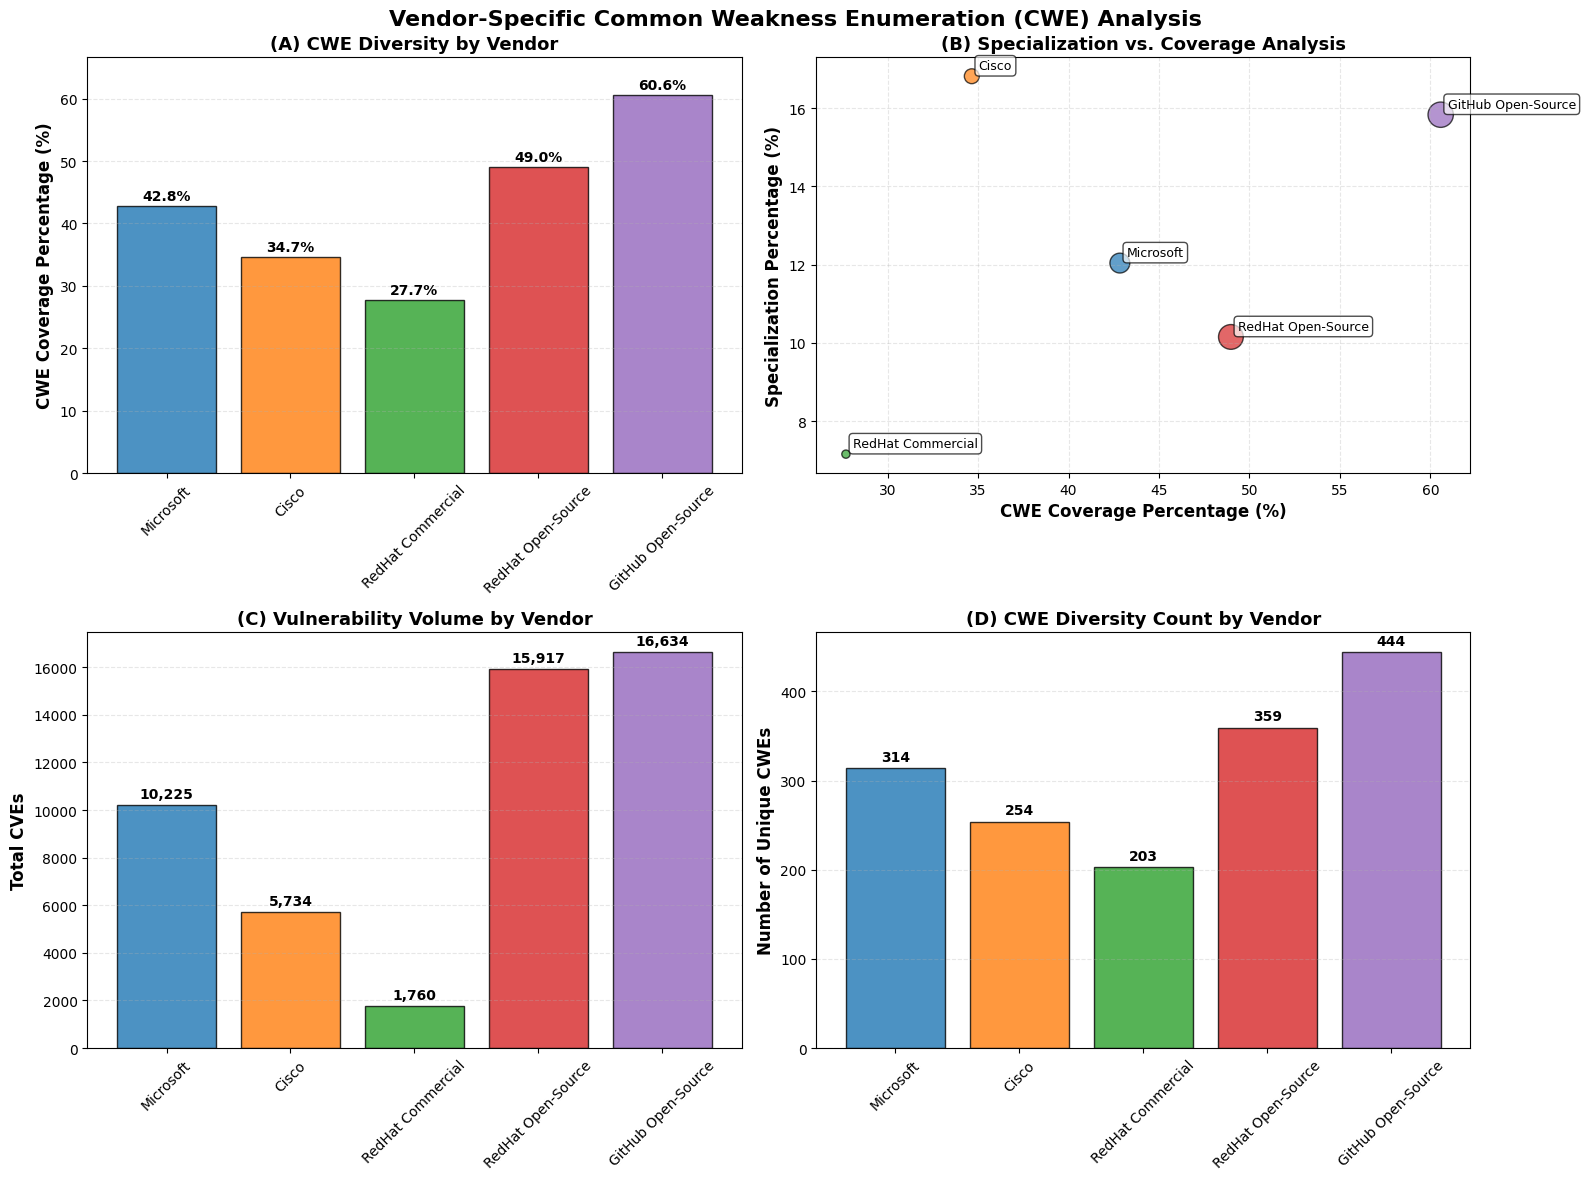

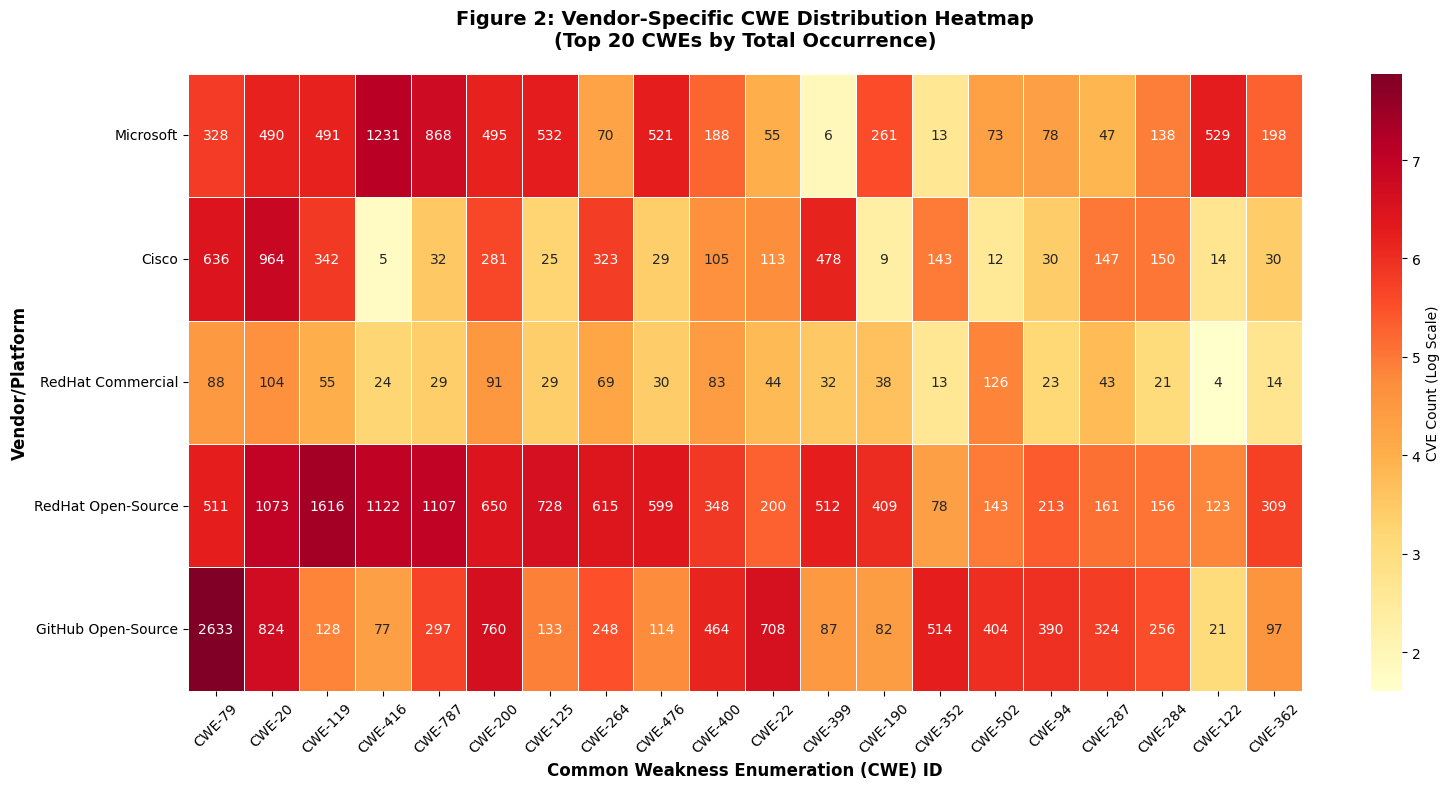

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


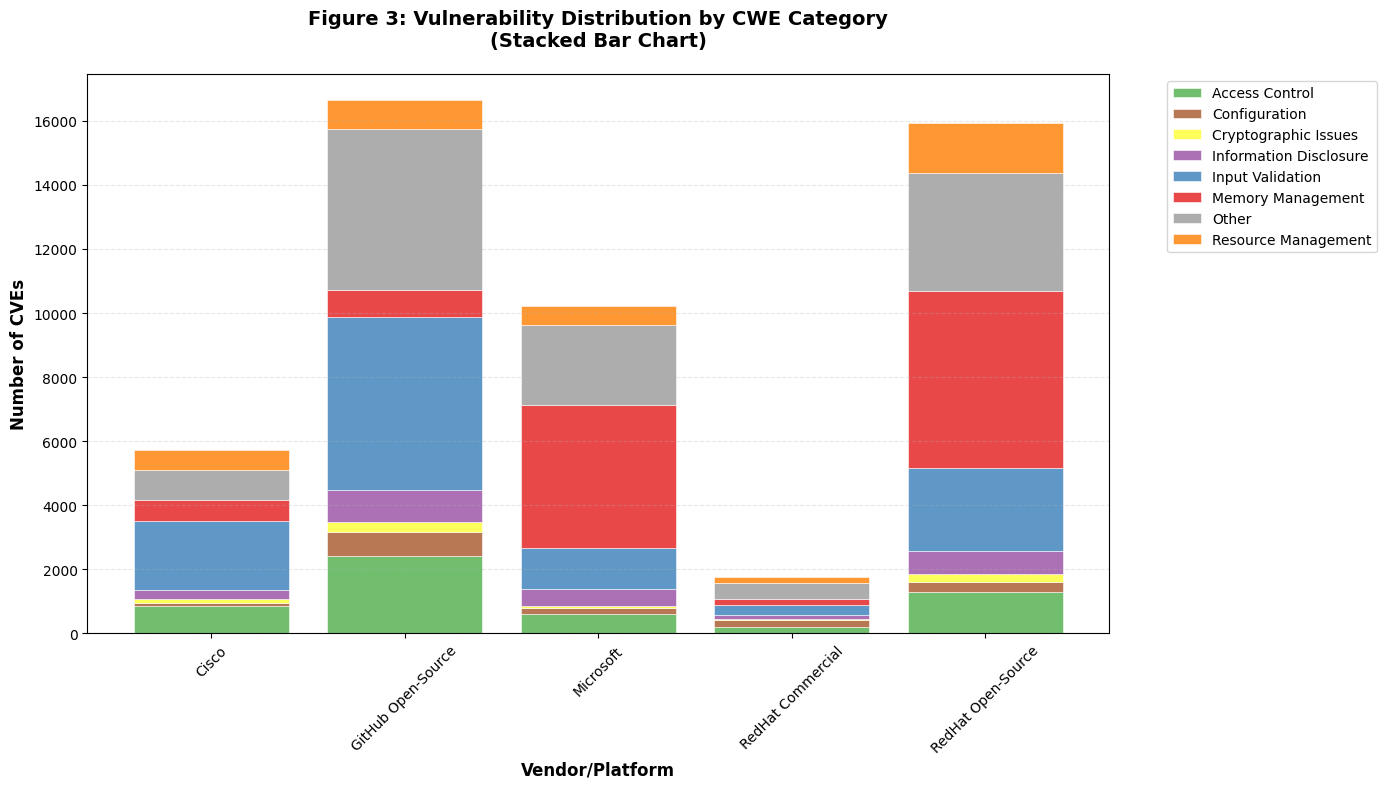

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


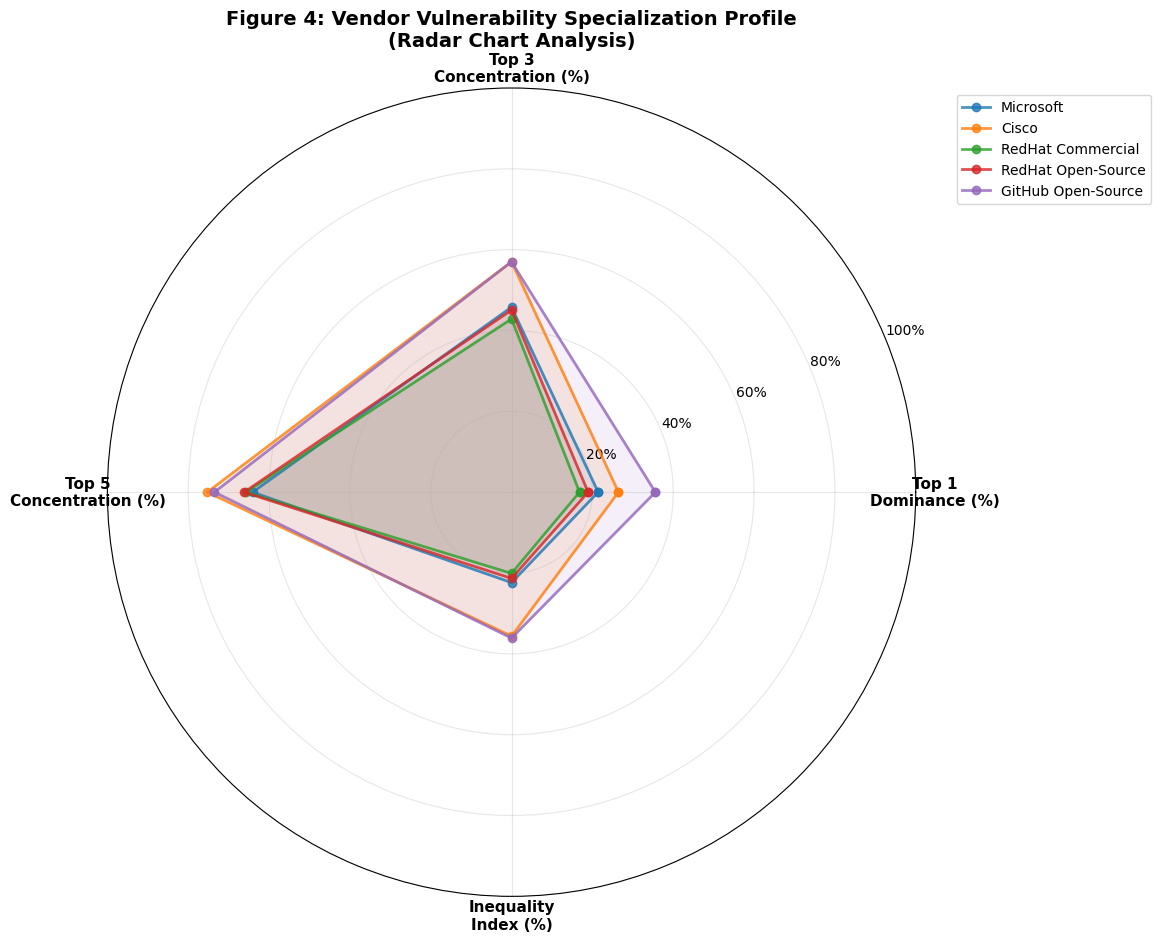

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


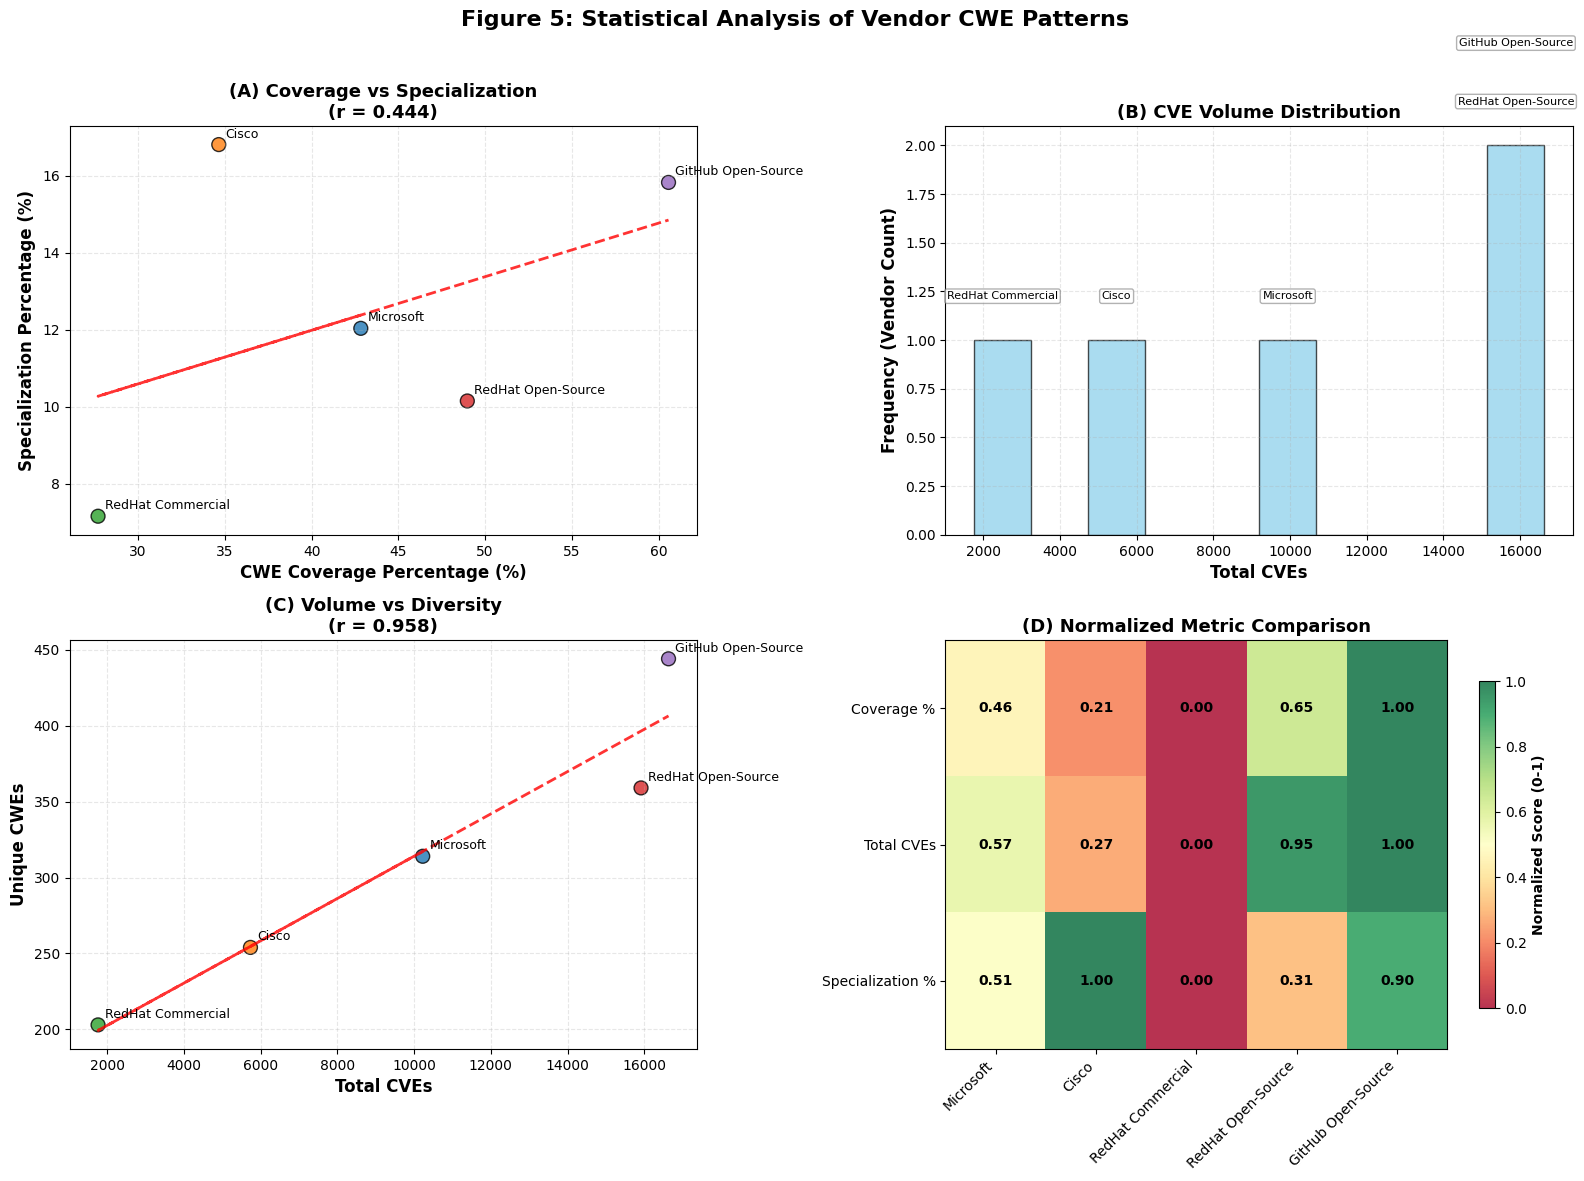


ACADEMIC SUMMARY STATISTICS
Dataset Overview:
• Total unique CWEs analyzed: 733
• Number of vendors/platforms: 5
• Total CVEs across all vendors: 50,270

Coverage Statistics:
• Mean CWE coverage: 42.9% (SD: 12.7%)
• Highest coverage: 60.6% (GitHub Open-Source)
• Lowest coverage: 27.7% (RedHat Commercial)

Specialization Statistics:
• Mean specialization: 12.4% (SD: 4.0%)
• Most specialized: 16.8% (Cisco)
• Least specialized: 7.2% (RedHat Commercial)

Correlation Analysis:
• Coverage vs Specialization: r = 0.444
• Volume vs Diversity: r = 0.958

GENERATED ACADEMIC FIGURES:
• Figure1_Vendor_CWE_Comprehensive_Analysis.png/.eps
• Figure2_CWE_Vendor_Heatmap.png/.eps
• Figure3_CWE_Category_Distribution.png/.eps
• Figure4_Vendor_Specialization_Radar.png/.eps
• Figure5_Statistical_Analysis.png/.eps

All figures saved in both PNG (presentation) and EPS (publication) formats.


In [ ]:
# Set academic style
plt.style.use('default')
sns.set_palette("husl")

def create_academic_cwe_visualizations(vendor_results):
    """
    Create publication-quality academic visualizations for CWE analysis
    """
    
    print("Creating Academic-Quality CWE Visualizations...")
    
    # Prepare data from vendor results
    vendors_data = {
        'Microsoft': {'data': vendor_results['microsoft'], 'count_col': 'ms_count', 'color': '#1f77b4'},
        'Cisco': {'data': vendor_results['cisco'], 'count_col': 'cisco_count', 'color': '#ff7f0e'},
        'RedHat Commercial': {'data': vendor_results['redhat_commercial'], 'count_col': 'rh_comm_count', 'color': '#2ca02c'},
        'RedHat Open-Source': {'data': vendor_results['redhat_opensource'], 'count_col': 'rh_os_count', 'color': '#d62728'},
        'GitHub Open-Source': {'data': vendor_results['github'], 'count_col': 'gh_count', 'color': '#9467bd'}
    }
    
    # Create summary statistics
    summary_stats = []
    for vendor, info in vendors_data.items():
        if not info['data'].empty:
            total_cves = info['data'][info['count_col']].sum()
            unique_cwes = len(info['data'])
            top_cwe = info['data'].iloc[0]['cwe_id']
            top_count = info['data'].iloc[0][info['count_col']]
            specialization = (top_count / total_cves) * 100
            coverage = (unique_cwes / vendor_results['total_cwes']) * 100
            
            summary_stats.append({
                'Vendor': vendor,
                'Total_CVEs': total_cves,
                'Unique_CWEs': unique_cwes,
                'Coverage_Percent': coverage,
                'Specialization_Percent': specialization,
                'Top_CWE': top_cwe,
                'Top_Count': top_count,
                'Color': info['color']
            })
    
    summary_df = pd.DataFrame(summary_stats)
    
    # =================================================================
    # FIGURE 1: Comprehensive Vendor Comparison (2x2 Grid)
    # =================================================================
    
    fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig1.suptitle('Vendor-Specific Common Weakness Enumeration (CWE) Analysis', 
                  fontsize=16, fontweight='bold', y=0.98)
    
    # Subplot A: CWE Coverage Percentage
    bars1 = ax1.bar(summary_df['Vendor'], summary_df['Coverage_Percent'], 
                   color=summary_df['Color'], alpha=0.8, edgecolor='black', linewidth=1)
    
    ax1.set_ylabel('CWE Coverage Percentage (%)', fontsize=12, fontweight='bold')
    ax1.set_title('(A) CWE Diversity by Vendor', fontsize=13, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.set_ylim(0, max(summary_df['Coverage_Percent']) * 1.1)
    
    # Add value labels
    for bar, value in zip(bars1, summary_df['Coverage_Percent']):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Rotate x-axis labels
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', labelsize=10)
    
    # Subplot B: Specialization vs Coverage Scatter
    scatter = ax2.scatter(summary_df['Coverage_Percent'], summary_df['Specialization_Percent'],
                         c=summary_df['Color'], s=summary_df['Total_CVEs']/50, 
                         alpha=0.7, edgecolors='black', linewidth=1)
    
    ax2.set_xlabel('CWE Coverage Percentage (%)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Specialization Percentage (%)', fontsize=12, fontweight='bold')
    ax2.set_title('(B) Specialization vs. Coverage Analysis', fontsize=13, fontweight='bold')
    ax2.grid(alpha=0.3, linestyle='--')
    
    # Add vendor labels
    for _, row in summary_df.iterrows():
        ax2.annotate(row['Vendor'], 
                    (row['Coverage_Percent'], row['Specialization_Percent']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    ax2.tick_params(axis='both', labelsize=10)
    
    # Subplot C: Total CVEs Distribution
    bars3 = ax3.bar(summary_df['Vendor'], summary_df['Total_CVEs'], 
                   color=summary_df['Color'], alpha=0.8, edgecolor='black', linewidth=1)
    
    ax3.set_ylabel('Total CVEs', fontsize=12, fontweight='bold')
    ax3.set_title('(C) Vulnerability Volume by Vendor', fontsize=13, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for bar, value in zip(bars3, summary_df['Total_CVEs']):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + max(summary_df['Total_CVEs']) * 0.01,
                f'{int(value):,}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax3.tick_params(axis='x', rotation=45, labelsize=10)
    ax3.tick_params(axis='y', labelsize=10)
    
    # Subplot D: Unique CWEs Count
    bars4 = ax4.bar(summary_df['Vendor'], summary_df['Unique_CWEs'], 
                   color=summary_df['Color'], alpha=0.8, edgecolor='black', linewidth=1)
    
    ax4.set_ylabel('Number of Unique CWEs', fontsize=12, fontweight='bold')
    ax4.set_title('(D) CWE Diversity Count by Vendor', fontsize=13, fontweight='bold')
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for bar, value in zip(bars4, summary_df['Unique_CWEs']):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{int(value)}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax4.tick_params(axis='x', rotation=45, labelsize=10)
    ax4.tick_params(axis='y', labelsize=10)
    
    plt.tight_layout()
    plt.savefig('Figure1_Vendor_CWE_Comprehensive_Analysis.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.savefig('Figure1_Vendor_CWE_Comprehensive_Analysis.eps', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.show()
    
    # =================================================================
    # FIGURE 2: Top CWEs Comparison Heatmap
    # =================================================================
    
    # Prepare data for heatmap - Top 15 CWEs across all vendors
    all_cwes = set()
    for vendor, info in vendors_data.items():
        if not info['data'].empty:
            all_cwes.update(info['data'].head(15)['cwe_id'].tolist())
    
    # Create matrix for heatmap
    heatmap_data = []
    vendor_names = []
    
    for vendor, info in vendors_data.items():
        if not info['data'].empty:
            vendor_names.append(vendor)
            vendor_row = []
            vendor_data_dict = dict(zip(info['data']['cwe_id'], info['data'][info['count_col']]))
            
            for cwe in sorted(all_cwes):
                vendor_row.append(vendor_data_dict.get(cwe, 0))
            heatmap_data.append(vendor_row)
    
    heatmap_df = pd.DataFrame(heatmap_data, 
                             index=vendor_names, 
                             columns=sorted(all_cwes))
    
    # Select top 20 CWEs by total occurrence
    cwe_totals = heatmap_df.sum(axis=0).sort_values(ascending=False)
    top_cwes = cwe_totals.head(20).index.tolist()
    heatmap_subset = heatmap_df[top_cwes]
    
    # Create heatmap
    fig2, ax = plt.subplots(figsize=(16, 8))
    
    # Use log scale for better visualization
    heatmap_log = np.log1p(heatmap_subset)  # log(1+x) to handle zeros
    
    sns.heatmap(heatmap_log, annot=heatmap_subset, fmt='g', cmap='YlOrRd', 
                ax=ax, cbar_kws={'label': 'CVE Count (Log Scale)'}, 
                linewidths=0.5, linecolor='white')
    
    ax.set_title('Figure 2: Vendor-Specific CWE Distribution Heatmap\n(Top 20 CWEs by Total Occurrence)', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Common Weakness Enumeration (CWE) ID', fontsize=12, fontweight='bold')
    ax.set_ylabel('Vendor/Platform', fontsize=12, fontweight='bold')
    
    # Improve tick labels
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', rotation=0, labelsize=10)
    
    plt.tight_layout()
    plt.savefig('Figure2_CWE_Vendor_Heatmap.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.savefig('Figure2_CWE_Vendor_Heatmap.eps', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.show()
    
    # =================================================================
    # FIGURE 3: CWE Category Analysis
    # =================================================================
    
    # Define CWE categories for academic analysis
    cwe_categories = {
        'Memory Management': ['CWE-119', 'CWE-120', 'CWE-121', 'CWE-122', 'CWE-125', 'CWE-126', 
                             'CWE-416', 'CWE-476', 'CWE-787', 'CWE-822', 'CWE-824'],
        'Input Validation': ['CWE-20', 'CWE-79', 'CWE-89', 'CWE-94', 'CWE-190', 'CWE-22', 
                            'CWE-78', 'CWE-77', 'CWE-91'],
        'Access Control': ['CWE-264', 'CWE-269', 'CWE-284', 'CWE-285', 'CWE-287', 'CWE-352', 
                          'CWE-862', 'CWE-863', 'CWE-918'],
        'Information Disclosure': ['CWE-200', 'CWE-209', 'CWE-215', 'CWE-359', 'CWE-532'],
        'Resource Management': ['CWE-399', 'CWE-400', 'CWE-401', 'CWE-770', 'CWE-771', 'CWE-362'],
        'Cryptographic Issues': ['CWE-310', 'CWE-311', 'CWE-326', 'CWE-327', 'CWE-347'],
        'Configuration': ['CWE-16', 'CWE-502', 'CWE-611', 'CWE-693', 'CWE-444']
    }
    
    # Calculate category distributions for each vendor
    category_data = []
    
    for vendor, info in vendors_data.items():
        if not info['data'].empty:
            vendor_categories = {cat: 0 for cat in cwe_categories.keys()}
            vendor_categories['Other'] = 0
            
            for _, row in info['data'].iterrows():
                cwe_id = row['cwe_id']
                count = row[info['count_col']]
                
                categorized = False
                for category, cwes in cwe_categories.items():
                    if cwe_id in cwes:
                        vendor_categories[category] += count
                        categorized = True
                        break
                
                if not categorized:
                    vendor_categories['Other'] += count
            
            for category, count in vendor_categories.items():
                category_data.append({
                    'Vendor': vendor,
                    'Category': category,
                    'Count': count,
                    'Color': info['color']
                })
    
    category_df = pd.DataFrame(category_data)
    
    # Create stacked bar chart
    fig3, ax = plt.subplots(figsize=(14, 8))
    
    # Pivot data for stacked bar chart
    pivot_df = category_df.pivot(index='Vendor', columns='Category', values='Count').fillna(0)
    
    # Define colors for categories
    category_colors = {
        'Memory Management': '#e41a1c',
        'Input Validation': '#377eb8', 
        'Access Control': '#4daf4a',
        'Information Disclosure': '#984ea3',
        'Resource Management': '#ff7f00',
        'Cryptographic Issues': '#ffff33',
        'Configuration': '#a65628',
        'Other': '#999999'
    }
    
    # Create stacked bars
    bottom = np.zeros(len(pivot_df))
    
    for category in pivot_df.columns:
        if category in category_colors:
            ax.bar(pivot_df.index, pivot_df[category], bottom=bottom, 
                  label=category, color=category_colors[category], alpha=0.8, 
                  edgecolor='white', linewidth=0.5)
            bottom += pivot_df[category]
    
    ax.set_title('Figure 3: Vulnerability Distribution by CWE Category\n(Stacked Bar Chart)', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Vendor/Platform', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of CVEs', fontsize=12, fontweight='bold')
    
    # Improve legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    # Rotate x-axis labels
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig('Figure3_CWE_Category_Distribution.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.savefig('Figure3_CWE_Category_Distribution.eps', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.show()
    
    # =================================================================
    # FIGURE 4: Vendor Specialization Analysis (Radar Chart)
    # =================================================================
    
    # Calculate specialization metrics for each vendor
    specialization_metrics = []
    
    for vendor, info in vendors_data.items():
        if not info['data'].empty:
            data = info['data'].head(10)  # Top 10 CWEs
            
            # Calculate various specialization metrics
            total_top10 = data[info['count_col']].sum()
            top1_ratio = data.iloc[0][info['count_col']] / total_top10 * 100
            top3_ratio = data.head(3)[info['count_col']].sum() / total_top10 * 100
            top5_ratio = data.head(5)[info['count_col']].sum() / total_top10 * 100
            
            # Gini coefficient for inequality
            counts = data[info['count_col']].values
            gini = 2 * np.sum(np.arange(1, len(counts) + 1) * np.sort(counts)) / (len(counts) * np.sum(counts)) - (len(counts) + 1) / len(counts)
            gini_normalized = gini * 100
            
            specialization_metrics.append({
                'Vendor': vendor,
                'Top_1_Dominance': top1_ratio,
                'Top_3_Concentration': top3_ratio,
                'Top_5_Concentration': top5_ratio,
                'Inequality_Index': gini_normalized,
                'Color': info['color']
            })
    
    spec_df = pd.DataFrame(specialization_metrics)
    
    # Create radar chart
    fig4, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))
    
    # Set up radar chart
    categories = ['Top 1\nDominance (%)', 'Top 3\nConcentration (%)', 
                 'Top 5\nConcentration (%)', 'Inequality\nIndex (%)']
    N = len(categories)
    
    # Compute angle for each category
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the circle
    
    # Plot each vendor
    for _, row in spec_df.iterrows():
        values = [row['Top_1_Dominance'], row['Top_3_Concentration'], 
                 row['Top_5_Concentration'], row['Inequality_Index']]
        values += values[:1]  # Complete the circle
        
        ax.plot(angles, values, 'o-', linewidth=2, label=row['Vendor'], 
               color=row['Color'], alpha=0.8, markersize=6)
        ax.fill(angles, values, alpha=0.1, color=row['Color'])
    
    # Customize radar chart
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=11, fontweight='bold')
    ax.set_ylim(0, 100)
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add title and legend
    plt.title('Figure 4: Vendor Vulnerability Specialization Profile\n(Radar Chart Analysis)', 
             fontsize=14, fontweight='bold', pad=30)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=10)
    
    plt.tight_layout()
    plt.savefig('Figure4_Vendor_Specialization_Radar.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.savefig('Figure4_Vendor_Specialization_Radar.eps', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.show()
    
    # =================================================================
    # FIGURE 5: Statistical Analysis and Correlations
    # =================================================================
    
    fig5, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig5.suptitle('Figure 5: Statistical Analysis of Vendor CWE Patterns', 
                  fontsize=16, fontweight='bold', y=0.98)
    
    # Subplot A: Coverage vs Specialization Correlation
    x = summary_df['Coverage_Percent']
    y = summary_df['Specialization_Percent']
    
    # Calculate correlation
    correlation = np.corrcoef(x, y)[0, 1]
    
    ax1.scatter(x, y, c=summary_df['Color'], s=100, alpha=0.8, edgecolors='black')
    
    # Add trend line
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax1.plot(x, p(x), "r--", alpha=0.8, linewidth=2)
    
    ax1.set_xlabel('CWE Coverage Percentage (%)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Specialization Percentage (%)', fontsize=12, fontweight='bold')
    ax1.set_title(f'(A) Coverage vs Specialization\n(r = {correlation:.3f})', 
                 fontsize=13, fontweight='bold')
    ax1.grid(alpha=0.3, linestyle='--')
    
    # Add vendor labels
    for _, row in summary_df.iterrows():
        ax1.annotate(row['Vendor'], (row['Coverage_Percent'], row['Specialization_Percent']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Subplot B: CVE Volume Distribution
    # --- Subplot B: CVE Volume Distribution (Histogram with Vendor Labels) ---
    
    n_bins = 10  # Adjust bin count as needed
    counts, bins, patches = ax2.hist(
        summary_df['Total_CVEs'], 
        bins=n_bins, 
        color='skyblue', 
        edgecolor='black', 
        alpha=0.7
    )

    # Label vendors in each bin with vertical stacking
    for i, (bin_start, bin_end) in enumerate(zip(bins[:-1], bins[1:])):
        vendors_in_bin = summary_df[
            (summary_df['Total_CVEs'] >= bin_start) & 
            (summary_df['Total_CVEs'] < bin_end)
        ]['Vendor'].tolist()

        # Fix the upper bound issue: include right edge for last bin
        if i == len(bins) - 2:
            vendors_in_bin += summary_df[
                (summary_df['Total_CVEs'] == bin_end)
            ]['Vendor'].tolist()

        # Place each vendor label slightly above the bar with vertical stacking
        for j, vendor in enumerate(vendors_in_bin):
            ax2.text(
                (bin_start + bin_end) / 2,        # x: center of the bin
                counts[i] + 0.2 + (j * 0.3),       # y: staggered vertically
                vendor,
                ha='center',
                va='bottom',
                fontsize=8,
                bbox=dict(boxstyle="round,pad=0.2", edgecolor='gray', facecolor='white', alpha=0.6)
            )

    ax2.set_xlabel('Total CVEs', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Frequency (Vendor Count)', fontsize=12, fontweight='bold')
    ax2.set_title('(B) CVE Volume Distribution', fontsize=13, fontweight='bold')
    ax2.grid(alpha=0.3, linestyle='--')



    
    
    # Subplot C: CWE Diversity vs CVE Volume
    ax3.scatter(summary_df['Total_CVEs'], summary_df['Unique_CWEs'], 
               c=summary_df['Color'], s=100, alpha=0.8, edgecolors='black')
    
    # Add trend line
    x_vol = summary_df['Total_CVEs']
    y_div = summary_df['Unique_CWEs']
    correlation2 = np.corrcoef(x_vol, y_div)[0, 1]
    
    z2 = np.polyfit(x_vol, y_div, 1)
    p2 = np.poly1d(z2)
    ax3.plot(x_vol, p2(x_vol), "r--", alpha=0.8, linewidth=2)
    
    ax3.set_xlabel('Total CVEs', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Unique CWEs', fontsize=12, fontweight='bold')
    ax3.set_title(f'(C) Volume vs Diversity\n(r = {correlation2:.3f})', 
                 fontsize=13, fontweight='bold')
    ax3.grid(alpha=0.3, linestyle='--')
    
    # Add vendor labels
    for _, row in summary_df.iterrows():
        ax3.annotate(row['Vendor'], (row['Total_CVEs'], row['Unique_CWEs']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Subplot D: Vendor Ranking Matrix
    metrics = ['Coverage_Percent', 'Total_CVEs', 'Specialization_Percent']
    metric_names = ['Coverage %', 'Total CVEs', 'Specialization %']
    
    # Normalize metrics to 0-1 scale for comparison
    normalized_data = summary_df[metrics].copy()
    for col in metrics:
        normalized_data[col] = (normalized_data[col] - normalized_data[col].min()) / (normalized_data[col].max() - normalized_data[col].min())
    
    # Create ranking heatmap
    im = ax4.imshow(normalized_data.T, cmap='RdYlGn', aspect='auto', alpha=0.8)
    
    # Set ticks and labels
    ax4.set_xticks(range(len(summary_df)))
    ax4.set_xticklabels(summary_df['Vendor'], rotation=45, ha='right')
    ax4.set_yticks(range(len(metric_names)))
    ax4.set_yticklabels(metric_names)
    
    # Add text annotations
    for i in range(len(metric_names)):
        for j in range(len(summary_df)):
            text = ax4.text(j, i, f'{normalized_data.iloc[j, i]:.2f}',
                           ha="center", va="center", color="black", fontweight='bold')
    
    ax4.set_title('(D) Normalized Metric Comparison', fontsize=13, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax4, shrink=0.8)
    cbar.set_label('Normalized Score (0-1)', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('Figure5_Statistical_Analysis.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.savefig('Figure5_Statistical_Analysis.eps', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.show()
    
    # =================================================================
    # Print Summary Statistics for Academic Paper
    # =================================================================
    
    print("\n" + "="*80)
    print("ACADEMIC SUMMARY STATISTICS")
    print("="*80)
    print(f"Dataset Overview:")
    print(f"• Total unique CWEs analyzed: {vendor_results['total_cwes']}")
    print(f"• Number of vendors/platforms: {len(summary_df)}")
    print(f"• Total CVEs across all vendors: {summary_df['Total_CVEs'].sum():,}")
    
    print(f"\nCoverage Statistics:")
    print(f"• Mean CWE coverage: {summary_df['Coverage_Percent'].mean():.1f}% (SD: {summary_df['Coverage_Percent'].std():.1f}%)")
    print(f"• Highest coverage: {summary_df['Coverage_Percent'].max():.1f}% ({summary_df.loc[summary_df['Coverage_Percent'].idxmax(), 'Vendor']})")
    print(f"• Lowest coverage: {summary_df['Coverage_Percent'].min():.1f}% ({summary_df.loc[summary_df['Coverage_Percent'].idxmin(), 'Vendor']})")
    
    print(f"\nSpecialization Statistics:")
    print(f"• Mean specialization: {summary_df['Specialization_Percent'].mean():.1f}% (SD: {summary_df['Specialization_Percent'].std():.1f}%)")
    print(f"• Most specialized: {summary_df['Specialization_Percent'].max():.1f}% ({summary_df.loc[summary_df['Specialization_Percent'].idxmax(), 'Vendor']})")
    print(f"• Least specialized: {summary_df['Specialization_Percent'].min():.1f}% ({summary_df.loc[summary_df['Specialization_Percent'].idxmin(), 'Vendor']})")
    
    print(f"\nCorrelation Analysis:")
    print(f"• Coverage vs Specialization: r = {correlation:.3f}")
    print(f"• Volume vs Diversity: r = {correlation2:.3f}")
    
    print("\n" + "="*80)
    print("GENERATED ACADEMIC FIGURES:")
    print("="*80)
    print("• Figure1_Vendor_CWE_Comprehensive_Analysis.png/.eps")
    print("• Figure2_CWE_Vendor_Heatmap.png/.eps") 
    print("• Figure3_CWE_Category_Distribution.png/.eps")
    print("• Figure4_Vendor_Specialization_Radar.png/.eps")
    print("• Figure5_Statistical_Analysis.png/.eps")
    print("\nAll figures saved in both PNG (presentation) and EPS (publication) formats.")
    
    return {
        'summary_stats': summary_df,
        'category_analysis': category_df,
        'specialization_metrics': spec_df,
        'correlations': {'coverage_specialization': correlation, 'volume_diversity': correlation2}
    }

# Execute visualization creation
# Note: This function should be called with the vendor_results from the previous analysis
print("Academic CWE Visualization Suite Ready!")
print("Usage: visualization_results = create_academic_cwe_visualizations(corrected_vendor_results)")
print("\nThis will generate 5 publication-quality figures suitable for academic papers.")

# After running the corrected vendor analysis:
visualization_results = create_academic_cwe_visualizations(fixed_results)

# This generates all 5 figures and returns statistical summary